In [17]:
import pandas as pd
import numpy as np
import datetime as datetime
import math
#from geopy import distance
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from tqdm import tqdm

tqdm.pandas()

/Users/clemencebarsi/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [11]:
data_folder = './data/'

# Method returning the dataframe obtained from the csv file named "name".
def get_dataframe(name):
    return pd.read_csv(data_folder + name, compression='gzip', sep='\t',header = None)

b_edges = get_dataframe('loc-brightkite_edges.txt.gz')
brightkite_checkins = get_dataframe('loc-brightkite_totalCheckins.txt.gz')
g_edges = get_dataframe('loc-gowalla_edges.txt.gz')
gowalla_checkins = get_dataframe('loc-gowalla_totalCheckins.txt.gz')
countries = pd.read_csv(data_folder + 'countries.csv')


In [12]:
#Renaming the columns in the given dataframes with the names given.
b_checkins = brightkite_checkins.rename(columns= {0: 'user', 1: 'checkin_time', 2: 'latitude', 
                                                       3: 'longitude', 4: 'location_id'})
g_checkins = gowalla_checkins.rename(columns= {0: 'user', 1: 'checkin_time', 2: 'latitude', 
                                                       3: 'longitude', 4: 'location_id'})

#Checking the number of checkins we have in each dataframe.
print("Number of checkins in Brightkite: " + str(len(b_checkins)))
print("Number of checkins in Gowalla: " + str(len(g_checkins)))
b_checkins.head()

Number of checkins in Brightkite: 4747287
Number of checkins in Gowalla: 6442892


,user,checkin_time,latitude,longitude,location_id
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc


In [13]:
# Checking for rows with impossible longitudes/latitudes and removing them if needed.

max_abs_latitude = 90
max_abs_longitude = 180

# Method verifying that the longitude and latitude values of row are valid.
def check_lat_long(row):
    return ((abs(row['latitude']) <= max_abs_latitude) & (abs(row['longitude']) <= max_abs_longitude))

# Any row with a "False" value for check_lat_long will be dropped from the dataframe.
b_checkins = b_checkins[b_checkins.apply(lambda row: check_lat_long(row), axis=1)]
g_checkins = g_checkins[g_checkins.apply(lambda row: check_lat_long(row), axis=1)]

print("Number of checkins in Brightkite: " + str(len(b_checkins)))
print("Number of checkins in Gowalla: " + str(len(g_checkins)))

Number of checkins in Brightkite: 4747172
Number of checkins in Gowalla: 6442863


In [14]:
# Creating a mask for all checkin locations that are not (0,0).
b_non_zero_mask = b_checkins.apply(lambda x : (x['latitude']!=0)&(x['longitude']!=0),axis = 1)
g_non_zero_mask = g_checkins.apply(lambda x : (x['latitude']!=0)&(x['longitude']!=0),axis = 1)

print("There are " + str((b_non_zero_mask == False).sum()) + " checkins with (0,0) as coordinates pair.")

There are 256207 checkins with (0,0) as coordinates pair.


## Placing the checkins in the continents

In [15]:
# Filtering out all the checkins made at location (lat,long) = (0,0).
b_checkins = b_checkins[b_non_zero_mask]
g_checkins = g_checkins[g_non_zero_mask]
#b_checkins.head()

In [25]:
countries = pd.read_csv(data_folder + 'countries.csv', sep = ';')
countries.set_index('area', inplace = True)
countries.head()

,bottom_left_lat,bottom_left_long,top_right_lat,top_right_long
area,,,,
usa,24.539159,-125.325272,49.000000,-60.128423
east europe,35.903991,-9.446662,59.159002,-4.601638
japan,29.895673,125.792187,45.652509,145.745126


In [24]:
countries['bottom_left'][0]

'(24.539159, -125.325272)'

In [29]:
def is_in_country(row, country):
    country_lat_range = range(int(country['bottom_left_lat']), int(country['top_right_lat'])+1)
    country_long_range = range(int(country['bottom_left_long']), int(country['top_right_long'])+1)
    return (int(row['latitude']) in country_lat_range) & (int(row['longitude']) in country_long_range)

In [30]:
b_checkins['is_in_usa'] = b_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)
g_checkins['is_in_usa'] = g_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)

#b_checkins.head()

100%|██████████| 6442727/6442727 [24:11<00:00, 4437.52it/s]  


In [31]:
b_checkins['is_in_europe'] = b_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['east europe']), axis=1)
g_checkins['is_in_europe'] = g_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['east europe']), axis=1)

#b_checkins.head()

100%|██████████| 6442727/6442727 [24:13<00:00, 4432.04it/s]


In [32]:
b_checkins['is_in_asia'] = b_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['japan']), axis=1)
g_checkins['is_in_asia'] = g_checkins.progress_apply(lambda row: is_in_country(row,countries.loc['japan']), axis=1)

#b_checkins.head()

100%|██████████| 6442727/6442727 [18:05:49<00:00, 98.89it/s]      


In [38]:
print('Brightkite in USA ' + str(len(b_checkins[b_checkins['is_in_usa']])))
print('Brightkite in Europe ' + str(len(b_checkins[b_checkins['is_in_europe']])))
print('Brightkite in Japan ' + str(len(b_checkins[b_checkins['is_in_asia']])))


Brightkite in USA 2923138
Brightkite in Europe 45972
Brightkite in Japan 422944


In [40]:
print('Gowalla in USA ' + str(len(g_checkins[g_checkins['is_in_usa']])))
print('Gowalla in Europe ' + str(len(g_checkins[g_checkins['is_in_europe']])))
print('Gowalla in Japan ' + str(len(g_checkins[g_checkins['is_in_asia']])))


Gowalla in USA 3675793
Gowalla in Europe 60913
Gowalla in Japan 66734


In [41]:
b_checkins = b_checkins[b_checkins['is_in_europe'] | b_checkins['is_in_usa'] | b_checkins['is_in_asia']]
g_checkins = g_checkins[g_checkins['is_in_europe'] | g_checkins['is_in_usa'] | g_checkins['is_in_asia']]

In [42]:
print(len(b_checkins))
print(len(g_checkins))

3392054
3803440


#### Interprétation:

je pense que faire ensuite un texte sur le fait que va y avoir des checkins qui vont correspondre à deux pays mais que c’est pas trop grave parce que ça veut dire que c’est des zones limitrophes et donc que elles ont potentiellement des influences culturelles des deux pays, particulierement en europe c’est pas mal nan?

In [43]:
b_checkins.to_csv(r'./data/b_checkins_with_countries.csv', compression='gzip')
g_checkins.to_csv(r'./data/g_checkins_with_countries.csv', compression='gzip')

In [48]:
b_checkins = pd.read_csv('Data/b_checkins_with_countries.csv', compression = 'gzip')
g_checkins = pd.read_csv('Data/g_checkins_with_countries.csv', compression = 'gzip')

Finding the homes of the users and classifying them in each continent

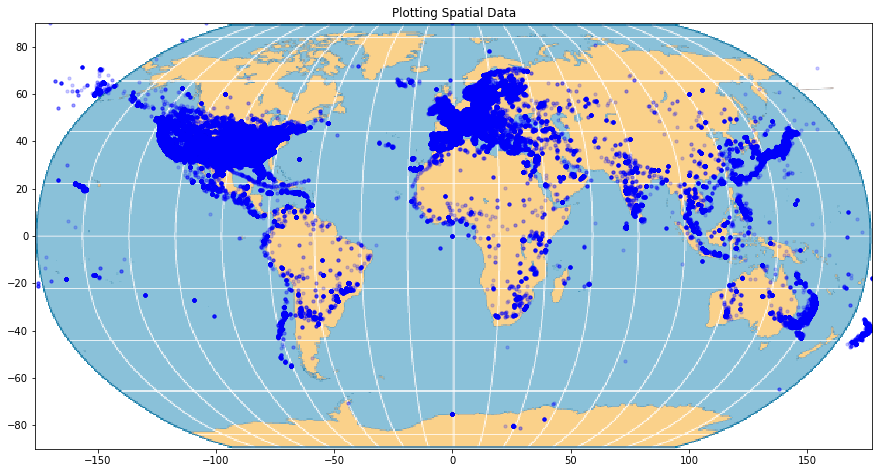

In [28]:
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(b_with_dist.longitude, b_with_dist.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(world_map, zorder=0, extent = BBox, aspect= 'equal')

## Making the conversions

We create the different functions and constants needed for assigning the locations to cells.
The function get_cell_coordinates gives the wanted coordinates of the cell given the latitude and longitude.

In [44]:
#lat_deg_in_km is the coefficient of conversion of a latitude in degrees to latitude in kilometers
#side_of_square is the size of the side of the cells in the discretized world in kilometers
#long_deg_in_km is the constant coefficient of conversion of a longitude in degrees to kilometers

lat_deg_in_km = 110.574
side_of_square = 25
long_deg_in_km = 111.3290

In [45]:
#the function long_deg_to_km returns the total coefficent of conversion of a longitude in degrees to kilometers in function 
#of the latitude and long_deg_in_km
def long_deg_to_km(lat):
    return long_deg_in_km*np.cos(lat)


#get_cell_coordinates obtains the coordinates in the discretized world (squares of 25 by 25 km) from a location in
#latitude and longitude, we simply multiply the latitude by lat_deg_in_km and divide it by side_of_square
#and multiply the longitude by long_deg_to_km(lat) and divide it by side_of_square
def get_cell_coordinates(lat, long):
    x_coord = int((long*long_deg_to_km(lat))/side_of_square)
    y_coord = int((lat*lat_deg_in_km)/side_of_square)
    return (x_coord, y_coord)

## Assigning cells

Now we can assign to the locations the corresponding coordinates in the discrertized world. We simply add a new column in each checkin dataframe and apply to it the previously made get_cell_coordinates function.

In [46]:
#we add a new column to the dataframe checkin_b. This column(named cell_coord) contains the coordinates of the checkins
#in the discretized world. We obtain it by simply applying the function get_cell_coordinates to each row
b_checkins['cell_coord'] = b_checkins.progress_apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)
g_checkins['cell_coord'] = g_checkins.progress_apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)


In [26]:
print('There is : '+str(nber_french_users)+' french users')
print('There is : '+str(nber_spain_users)+' spanish users')
print('There is : '+str(nber_uk_users)+' english users')
print('There is : '+str(nber_french_users+nber_spain_users+nber_uk_users)+' european users')
print('There is : '+str(nber_sweden_users)+' swedish users')
print('There is : '+str(nber_french_users+nber_spain_users+nber_uk_users+nber_sweden_users)+' european users')
print('\n')
print('There is : '+str(nber_usa_users)+' american users')

There is : 540 french users
There is : 1125 spanish users
There is : 4406 english users
There is : 6071 european users
There is : 1231 swedish users
There is : 7302 european users


There is : 47171 american users


## 3. Finding the homes of the users

We now want to find the home of each user. It is assumed that it is the cell that has the most checkins of this user. If there are several cells with the maximum number of checkins, I just kept the one that appeared first in the Dataframe. If there are two cells that have the maximum number of checkins, this is probably because one is the home and the other the worlplace.

In [47]:
#This function finds the homes of the users given a dataframe containing all the checkins(with columns : user,
#cell_coords, latitudes and longitudes)

def finding_homes(df):
    
    #We insert a column count (that for the moment countains only ones) in the dataframe that will contain how many 
    #checkins were made by a user in a cell_coord
    df.insert(0, "count", [1]*df.shape[0], True)
    
    #To count the number of checkins, we do a groupby on user and cell_coord. We count the number of checkins in each
    #groupby, and to obtain the latitude and longitude of checkins in this cell, we do a mean of all latitudes and
    #longitudes that are in this cell. We drop the rows with NaNs in them and reset the index for convenience
    df = df.groupby(['user', 'cell_coord']).agg({'count' : 'count', 'latitude' : 'mean', 'longitude':'mean'})
    df.dropna(axis=0, inplace=True)
    df.reset_index(inplace = True)
    
    #We sort the values by descending order in count, so that the cells with the most count are at the top for each user
    df.sort_values(by = 'count', ascending=False, inplace = True)
    
    #We drop the duplicates of user to keep only the cell with the biggest count as it is at the top. For convenience
    #we set user as the index sorted by ascending order
    df.drop_duplicates(subset = 'user', keep= 'first', inplace=True)
    df.sort_values(by='user', inplace=True)
    df.set_index('user', inplace = True)
    return df

In [48]:
#We call the function finding_homes on the checkins in Brightkite

homes_in_b = b_checkins[['user', 'cell_coord', 'latitude', 'longitude']]
homes_in_b = finding_homes(homes_in_b)
homes_in_b.reset_index(inplace = True)
homes_in_b.head()

,user,cell_coord,count,latitude,longitude
0,0,"(272, 176)",229,39.891261,-105.068678
1,1,"(-543, 166)",357,37.628486,-122.419079
2,2,"(211, 175)",305,39.739295,-104.982155
3,3,"(-543, 167)",549,37.777024,-122.404865
4,4,"(-543, 167)",131,37.779107,-122.410060


In [49]:
homes_in_g = g_checkins[['user', 'cell_coord', 'latitude', 'longitude']]
homes_in_g = finding_homes(homes_in_g)
homes_in_g.reset_index(inplace = True)
homes_in_g.head()

,user,cell_coord,count,latitude,longitude
0,0,"(-179, 133)",35,30.269307,-97.749469
1,2,"(-536, 167)",317,37.869730,-122.260862
2,4,"(-543, 167)",94,37.783623,-122.409399
3,5,"(-183, 133)",11,30.279888,-97.719816
4,7,"(-179, 133)",26,30.269299,-97.748892


In [50]:
homes_in_b['is_in_europe'] = homes_in_b.progress_apply(lambda row: is_in_country(row, countries.loc['east europe']), axis=1)
homes_in_g['is_in_europe'] = homes_in_g.progress_apply(lambda row: is_in_country(row, countries.loc['east europe']), axis=1)



In [52]:
homes_in_b['is_in_usa'] = homes_in_b.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)
homes_in_g['is_in_usa'] = homes_in_g.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)


100%|██████████| 58331/58331 [00:43<00:00, 1339.19it/s]


In [53]:
homes_in_b['is_in_asia'] = homes_in_b.progress_apply(lambda row: is_in_country(row, countries.loc['japan']), axis=1)
homes_in_g['is_in_asia'] = homes_in_g.progress_apply(lambda row: is_in_country(row, countries.loc['japan']), axis=1)


100%|██████████| 58331/58331 [00:29<00:00, 1986.02it/s]


In [55]:
homes_in_b.to_csv('homes_in_b.txt.gz', compression = 'gzip')
homes_in_g.to_csv('homes_in_g.txt.gz', compression = 'gzip')

## Print users in countries

TODO : calculer area

In [58]:
print('Users in Brightkite in East Asia : ' + str(len(homes_in_b[homes_in_b['is_in_asia']])))
print('Users in Brightkite in Europe : ' + str(len(homes_in_b[homes_in_b['is_in_europe']])))
print('Users in Brightkite in USA : ' + str(len(homes_in_b[homes_in_b['is_in_usa']])))

Users in Brightkite in East Asia : 3089
Users in Brightkite in Europe : 1090
Users in Brightkite in USA : 33048


In [61]:
print('Users in Gowalla in East Asia : ' + str(len(homes_in_g[homes_in_g['is_in_asia']])))
print('Users in Gowalla in Europe : ' + str(len(homes_in_g[homes_in_g['is_in_europe']])))
print('Users in Gowalla in USA : ' + str(len(homes_in_g[homes_in_g['is_in_usa']])))

Users in Gowalla in East Asia : 1519
Users in Gowalla in Europe : 2333
Users in Gowalla in USA : 54479


In [62]:
homes_in_b.rename(columns = {'latitude' : 'lat_home', 'longitude' : 'long_home', 
                             'is_in_europe' : 'home_in_europe','is_in_asia' : 'home_in_asia',
                            'is_in_usa' : 'home_in_usa', 'cell_coord' : 'cell_home'}, inplace = True)

homes_in_g.rename(columns = {'latitude' : 'lat_home', 'longitude' : 'long_home', 
                             'is_in_europe' : 'home_in_europe','is_in_asia' : 'home_in_asia',
                            'is_in_usa' : 'home_in_usa', 'cell_coord' : 'cell_home'}, inplace = True)


In [63]:
def dist(lat_1, long_1, lat_2, long_2):
        return geodesic((lat_1, long_1), (lat_2, long_2)).km

In [64]:
b_checkins = pd.merge(b_checkins, homes_in_b, how = 'left', on = 'user')
g_checkins = pd.merge(g_checkins, homes_in_g, how = 'left', on = 'user')


In [65]:
b_checkins = b_checkins[b_checkins['cell_home'] != b_checkins['cell_coord']]
g_checkins = g_checkins[g_checkins['cell_home'] != g_checkins['cell_coord']]

In [66]:
b_checkins['dist_from_home'] = b_checkins.progress_apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)

g_checkins['dist_from_home'] = g_checkins.progress_apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)

100%|██████████| 2902101/2902101 [23:48<00:00, 2031.42it/s] 


In [3]:
# Function that computes the distributions of the values in data and plots it using a scatter plot.
# The arguments are:
#    - data: the array containing the values for which we want to compute the distribution.
#    - ax: the axes of the plot on shich we will apply the scatter function.
#    - marker, color, m_size: type, edgecolor and size of the markers we want. m_size is set to 120 by default.
#    - bins_max, num_bins: max value for the logspace function, and number of values wanted for the bins. 
#                          Defalut values set respectively to 10^5 and 100 for this plot.
def plot_probability(data, ax, marker, color, label, m_size = 120, bins_max = pow(10,5), num_bins = 100):
    log_bins=np.logspace(0, np.log10(bins_max), num = num_bins)
    hist_values, bins = np.histogram(data, bins= log_bins, density=True)
    ax.scatter(bins[:-1], hist_values, marker= marker, s=m_size, facecolors='none', edgecolors=color, label=label)

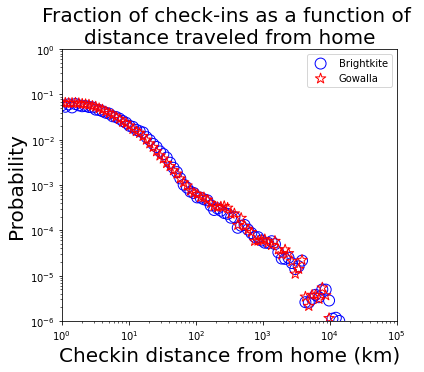

In [74]:
# Doing the final plot. Setting the figure size to (6,5) arbitrarily (slightly larger than tall).
fig, ax = plt.subplots(figsize=(6, 5))

# BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
plot_probability(b_checkins['dist_from_home'], ax, 'o', 'b', 'Brightkite')

# GOWALLA – computing and scatter plotting the distribution of home distances between friends.
plot_probability(g_checkins['dist_from_home'], ax, '*', 'r', 'Gowalla')

# Setting the axes' scales to be logarithmic.
ax.set_xscale("log")
ax.set_yscale("log")

#Setting the limits of the axes to match the ones in the paper's plot.
ax.set_xlim(10e-1, 10e4)
ax.set_ylim(10e-7, 10e-1)

# Naming the axes and resizing the labels
ax.set_xlabel('Checkin distance from home (km)', size=20)
ax.set_ylabel('Probability', size=20)

# Adding the color legend and the title of the plot.
ax.set_title("Fraction of check-ins as a function of \ndistance traveled from home", size=20)
ax.legend()

In [76]:
g_checkins.to_csv(r'./Data/g_with_dist.txt.gz', compression = 'gzip')

In [77]:
b_checkins.to_csv(r'./Data/b_with_dist.txt.gz', compression = 'gzip')

## TODO plot dist_from_home in each continent


## TODO plot dist_from_home for each event


## TODO statistical test 

stat_test : - same distribution between continents in checkins distance
            - same distribution between events/normal year day in each continent in checkins distance

# Plot the distribution of how far people tend to travel from their home on the special dates and on each continent

In [4]:
def get_dataframe_txt(name):
    return pd.read_csv(data_folder + name, compression='gzip', sep=',')
g_with_dist = get_dataframe_txt('g_with_dist.txt.gz')
b_with_dist = get_dataframe_txt('b_with_dist.txt.gz')

In [8]:
b_with_dist ['checkin_time'] = b_with_dist['checkin_time'].progress_apply(lambda x : pd.to_datetime(x))
g_with_dist ['checkin_time'] = g_with_dist['checkin_time'].progress_apply(lambda x : pd.to_datetime(x))

In [23]:
world_map = plt.imread('./Data/world_map4.png')

In [29]:
fig.savefig('b_checkins_plot.png')

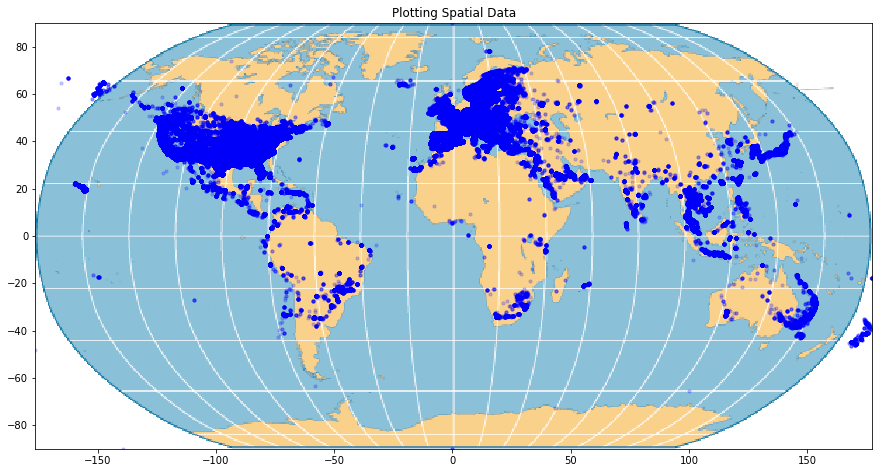

In [30]:
BBox = (g_with_dist.longitude.min(),g_with_dist.longitude.max(),g_with_dist.latitude.min(), g_with_dist.latitude.max())
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(g_with_dist.longitude, g_with_dist.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(world_map, zorder=0, extent = BBox, aspect= 'equal')

In [31]:
fig.savefig('g_checkins_plot.png')

In [25]:
events = pd.read_csv(data_folder+'important_events.csv', sep = ';')

In [26]:
events.columns = ['name_event', 'beggining_event', 'end_event', 'usa', 'east_asian_countries', 'iberic_countries', 'fr', 'gb',
                  'ger', 'nordic_countries', 'event_type']

In [27]:
events.beggining_event = pd.to_datetime(events.beggining_event, dayfirst=True)
events.end_event = pd.to_datetime(events.end_event, dayfirst=True)

In [28]:
events.head()

,name_event,beggining_event,end_event,usa,east_asian_countries,iberic_countries,fr,gb,ger,nordic_countries,event_type
0,Christmas,2008-12-20,2008-12-28,True,True,True,True,True,True,True,Religious Celebration
1,Christmas,2009-12-19,2009-12-27,True,False,True,True,True,True,True,Religious Celebration
2,Christmas,2010-12-18,2010-12-26,True,False,True,True,True,True,True,Religious Celebration
3,Saint-Nicolas,2008-12-05,2008-12-08,False,False,False,False,False,True,False,Religious Celebration
4,Saint-Nicolas,2009-12-04,2009-12-08,False,False,False,False,False,True,False,Religious Celebration


For each special event and each continent, we find how far from their home people tend to travel.

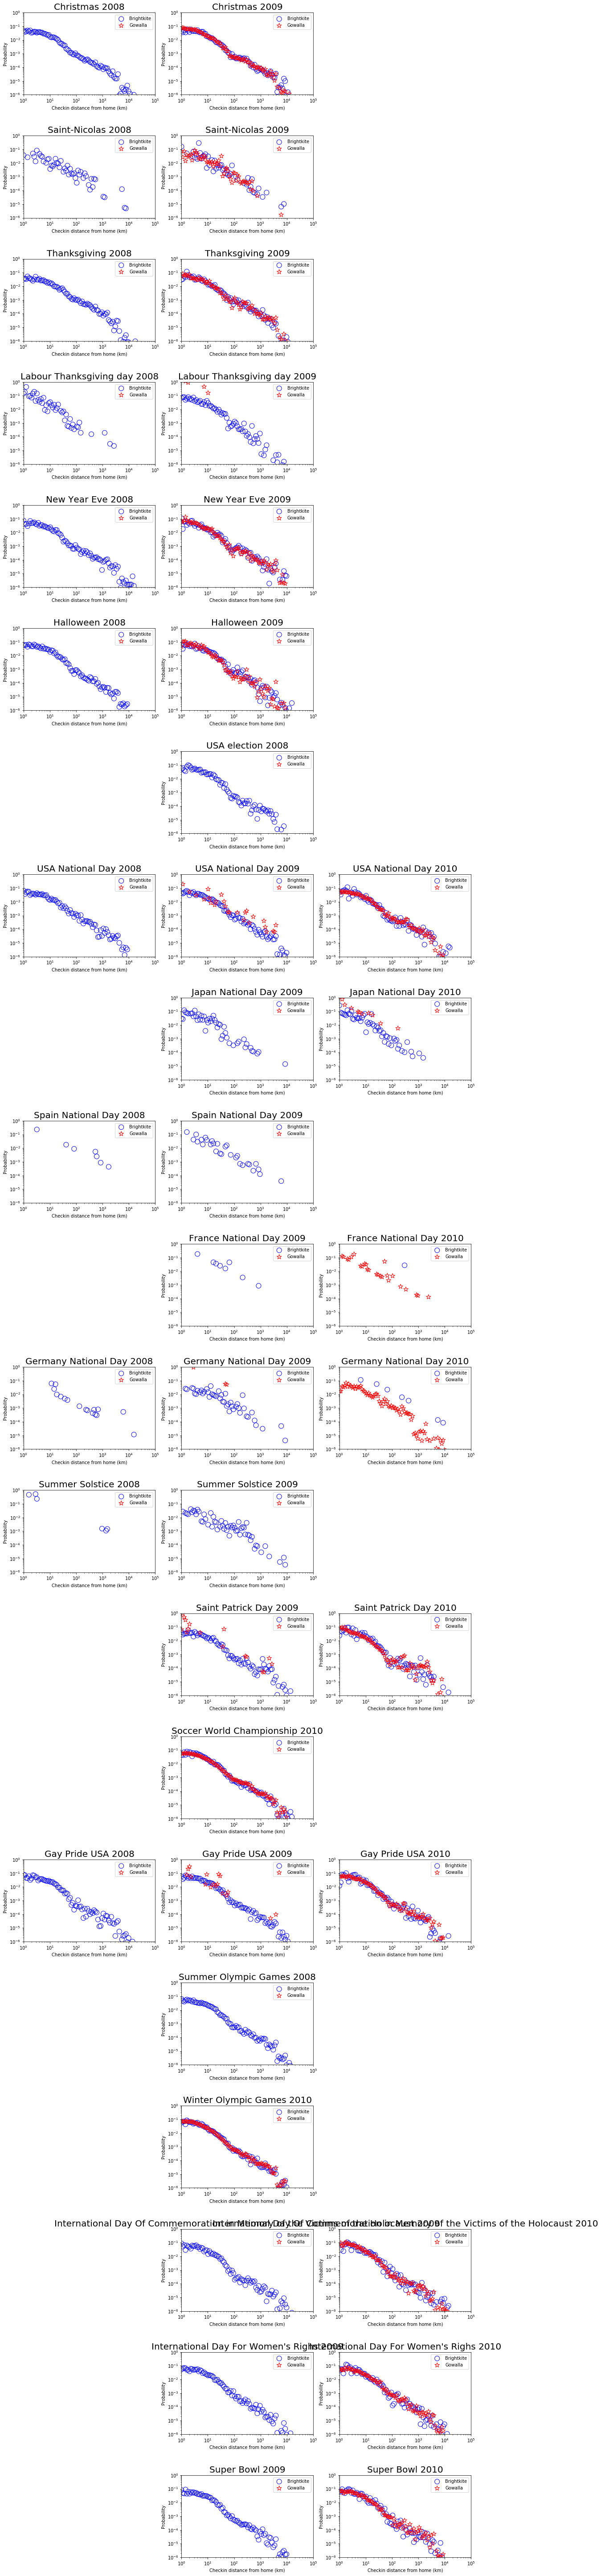

In [29]:
# Doing the final plot. Setting the figure size to (6,5) arbitrarily (slightly larger than tall).
fig, axs = plt.subplots(21,3, figsize=(6*3, 5*21))
    
utc=pytz.UTC

for idx, event in events.iterrows() :
    #select the ones in correct area of the world
    b_checkins_to_study = b_with_dist[
    (event.iberic_countries & b_with_dist.home_in_spain) | (event.gb & b_with_dist.home_in_gb) | 
    (event.fr & b_with_dist.home_in_france) | (event.usa & b_with_dist.home_in_usa) | 
    (event.nordic_countries & b_with_dist.home_in_sweden) | (event.ger & b_with_dist.home_in_germany) |
    (event.east_asian_countries & b_with_dist.home_in_japan)
    ]
    
    g_checkins_to_study = g_with_dist[
    (event.iberic_countries & g_with_dist.home_in_spain) | (event.gb & g_with_dist.home_in_gb) | 
    (event.fr & g_with_dist.home_in_france) | (event.usa & g_with_dist.home_in_usa) | 
    (event.nordic_countries & g_with_dist.home_in_sweden) | (event.ger & g_with_dist.home_in_germany) |
    (event.east_asian_countries & g_with_dist.home_in_japan)
    ]
    
    #select only the ones in the correct timestamps 
    b_checkins_to_study = b_checkins_to_study[(b_checkins_to_study.checkin_time <= utc.localize(event.end_event)) &
                                         (b_checkins_to_study.checkin_time >= utc.localize(event.beggining_event))]
    
    g_checkins_to_study = g_checkins_to_study[(g_checkins_to_study.checkin_time <= utc.localize(event.end_event)) &
                                         (g_checkins_to_study.checkin_time >= utc.localize(event.beggining_event))]
    
    if (b_checkins_to_study.empty & g_checkins_to_study.empty) :
        fig.delaxes(axs[idx//3, idx%3])
    else : 
        # BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
        plot_probability(b_checkins_to_study['dist_from_home'], axs[idx//3,idx%3], 'o', 'b', 'Brightkite')

        # GOWALLA – computing and scatter plotting the distribution of home distances between friends.
        plot_probability(g_checkins_to_study['dist_from_home'], axs[idx//3,idx%3], '*', 'r', 'Gowalla')

        # Setting the axes' scales to be logarithmic.
        axs[idx//3,idx%3].set_xscale("log")
        axs[idx//3,idx%3].set_yscale("log")

        #Setting the limits of the axes to match the ones in the paper's plot.
        axs[idx//3,idx%3].set_xlim(10e-1, 10e4)
        axs[idx//3,idx%3].set_ylim(10e-7, 10e-1)

        # Naming the axes and resizing the labels
        axs[idx//3,idx%3].set_xlabel('Checkin distance from home (km)', size=10)
        axs[idx//3,idx%3].set_ylabel('Probability', size=10)

        # Adding the color legend and the title of the plot.
        axs[idx//3,idx%3].set_title(event.name_event + ' '+str(event.beggining_event.year), size=20)
        axs[idx//3,idx%3].legend()

plt.subplots_adjust(hspace = 0.5)

In [113]:
events.shape

(43, 11)

## TODO plot average number of checkins per day overall and in each continent

## TODO  plot average number of checkins per average user in each continent

## TODO nbre de checkins autour des events in each continent

## TODO nber of checkins arount each event in function of the nber of friends

## TODO users checkins near friends arount each event ?


## OPT filter by top_user